<h1><center>REINFORCEMENT LEARNING FINAL PROJECT</center></h1>
<h3><center>TEAM 10</center></h3>

#### MEMBER 1: SURYA VENKATA ROHIT MOGANTI (SMOGANTI)
#### MEMBER 2: BAHVANI KIRAN (BHAVANIK)

In [1]:
# Cell 1: Import Libraries
import torch
import random
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
from IPython import display
import pygame
import os
from enum import Enum
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

pygame 2.6.1 (SDL 2.28.4, Python 3.12.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:

# Enable interactive plotting for immediate visual feedback in training
plt.ion()

# Initialize Pygame for game environment setup
pygame.init()

(5, 0)

### Function Significance

#### GRID_UNIT: 
This setting determines the size of each grid cell in the game. It affects how the snake moves and where food appears.
#### REFRESH_RATE: 
This setting determines how frequently the game refreshes its visuals. A lower value slows down the action, while a higher value speeds it up, affecting the game’s speed and challenge.
#### COLOR_BACKGROUND: 
This setting determines the color of the game’s background. For instance, (255, 255, 255) means white, giving a clean and neutral backdrop for everything else.
#### COLOR_GRID: 
This setting determines the color of the grid lines or the game boundary. Black (0, 0, 0) stands out against the background and game elements.
#### COLOR_SNAKE_HEAD: 
This sets the color of the snake’s head in RGB format. (0, 0, 255) means blue, which helps you spot the head from the body, making it easier to play.
#### COLOR_SNAKE_BODY: 
This specifies the RGB color of the snake’s body segments. (0, 100, 255) is a lighter blue than the head, making it easy to spot the body parts from the head.
#### COLOR_FOOD: 
This defines the RGB color for the food item in the game. (34, 139, 34) is a light green color, making it easy to spot against the other elements.
#### COLOR_HIT:
This color represents the RGB value used when the snake collides with something, like itself or the wall. (200, 0, 0) is a red color, which means there’s an error or a “hit” condition.
#### DIRECTION: 
An Enum that represents the possible movement directions for the snake (RIGHT, LEFT, UP, DOWN), which helps keep the snake in the game.
#### POSITION:
Let’s create a namedtuple to represent the x and y coordinates. This will make it easier to handle the positions of the snake’s head, body, and food items in the game grid.

In [3]:
# Define constants with custom names for flexibility in different games
GRID_UNIT = 20
REFRESH_RATE = 100
COLOR_BACKGROUND = (255, 255, 255)
COLOR_GRID = (0, 0, 0)
COLOR_SNAKE_HEAD = (0, 0, 255)
COLOR_SNAKE_BODY = (0, 100, 255)
COLOR_FOOD = (34, 139, 34)
COLOR_HIT = (200, 0, 0)

# Initialize font for UI text
font_style = pygame.font.Font(None, 35)
Direction = Enum('Direction', 'RIGHT LEFT UP DOWN')
Position = namedtuple('Position', 'x, y')

## Sanke Game Environment
The SnakeGameAI class sets up a game for a reinforcement learning agent to play Snake. It starts the game, putting the snake in its starting position and placing the food. The agent can take actions, which changes the snake’s movement and checks for collisions. A reward system gives the agent positive feedback for getting food and negative feedback for colliding, helping the agent learn good strategies. After each move, the game display is updated, showing the snake, food, and score. This class lets the agent learn by playing the game and getting better at maximizing rewards.

### SnakeGameAI Class: 
### Function Significance
Manages game setup, movement, and rendering on behalf of the Snake AI game.
#### init():
Sets the clock, game window, and snake state to their initial values.
#### Initialize_game():
Resets the score and snake position in the game.
#### generate_food(): 
Produces food locations on the grid at random.
#### perform_action():
Returns the game status and reward after carrying out a move in response to an activity.
#### evaluate_step(): 
Modifies the score and reward while checking the state of the game.
#### check_collision(): 
Determines whether the snake runs into obstacles or runs into itself.
#### move(): 
Modifies the snake's orientation and makes the appropriate movement.
#### update_ui(): 
The updated game display with the snake, food, and score is displayed 


In [4]:
class SnakeGameAI:
    
    def __init__(self, width=640, height=480):
        self.width = width
        self.height = height
        self.display = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption('SnakeGame AI')
        self.clock = pygame.time.Clock()
        self.highest_score = 0
        self._initialize_game()

    def _initialize_game(self):

        self.direction = Direction.RIGHT
        self.head = Position(self.width / 2, self.height / 2)
        self.snake = [self.head,
                      Position(self.head.x - GRID_UNIT, self.head.y),
                      Position(self.head.x - (2 * GRID_UNIT), self.head.y)]
        self.score = 0
        self.food = None
        self.frame_iteration = 0
        self._generate_food()

    def _generate_food(self):
        x = random.randint(0, (self.width - GRID_UNIT) // GRID_UNIT) * GRID_UNIT
        y = random.randint(0, (self.height - GRID_UNIT) // GRID_UNIT) * GRID_UNIT
        self.food = Position(x, y)
        if self.food in self.snake:
            self._generate_food()

    def perform_action(self, action):
        self.frame_iteration += 1
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()

        self._move(action)
        self.snake.insert(0, self.head)
        reward, game_over = self._evaluate_step()
        
        self._update_ui()
        self.clock.tick(REFRESH_RATE)
        return reward, game_over, self.score

    def _evaluate_step(self):
        reward, game_over = 0, False
        if self._check_collision() or self.frame_iteration > 100 * len(self.snake):
            game_over = True
            reward = -10
            self.highest_score = max(self.highest_score, self.score)
        elif self.head == self.food:
            self.score += 1
            reward = 10
            self._generate_food()
        else:
            self.snake.pop()
        return reward, game_over

    def _check_collision(self, point=None):
        if point is None:
            point = self.head
        if point.x > self.width - GRID_UNIT or point.x < 0 or point.y > self.height - GRID_UNIT or point.y < 0:
            return True
        if point in self.snake[1:]:
            return True
        return False

    def _move(self, action):
        clockwise_directions = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        direction_idx = clockwise_directions.index(self.direction)
        if np.array_equal(action, [1, 0, 0]):
            new_dir = clockwise_directions[direction_idx]
        elif np.array_equal(action, [0, 1, 0]):
            new_dir = clockwise_directions[(direction_idx + 1) % 4]
        else:
            new_dir = clockwise_directions[(direction_idx - 1) % 4]

        self.direction = new_dir
        x, y = self.head.x, self.head.y
        if self.direction == Direction.RIGHT:
            x += GRID_UNIT
        elif self.direction == Direction.LEFT:
            x -= GRID_UNIT
        elif self.direction == Direction.DOWN:
            y += GRID_UNIT
        elif self.direction == Direction.UP:
            y -= GRID_UNIT

        self.head = Position(x, y)

    def _update_ui(self):
        self.display.fill(COLOR_GRID)
    
        for pt in self.snake:
            pygame.draw.circle(self.display, COLOR_HIT, (pt.x + GRID_UNIT // 2, pt.y + GRID_UNIT // 2), GRID_UNIT // 2)
    
        pygame.draw.circle(self.display, COLOR_FOOD, (self.food.x + GRID_UNIT // 2, self.food.y + GRID_UNIT // 2), GRID_UNIT // 2)
    
        score_text = font_style.render("Score: " + str(self.score), True, COLOR_BACKGROUND)
        length_text = font_style.render("Length: " + str(len(self.snake)), True, COLOR_BACKGROUND)
        high_score_text = font_style.render("High Score: " + str(self.highest_score), True, COLOR_BACKGROUND)
    
        self.display.blit(score_text, [0, 0])
        self.display.blit(high_score_text, [0, 90])
        self.display.blit(length_text, [0, 60])
        pygame.display.flip()



### Helper Functions
#### get_state() : 
Using 11 features, such as direction, food placement, and threat detection, get_state() pulls the current game state and normalizes it into a vector for the AI model.
#### reset_env():
Returns the game's initial state and resets the gaming environment.


In [5]:
def get_state(env):

    head = env.snake[0]
    point_l = Position(head.x - GRID_UNIT, head.y)
    point_r = Position(head.x + GRID_UNIT, head.y)
    point_u = Position(head.x, head.y - GRID_UNIT)
    point_d = Position(head.x, head.y + GRID_UNIT)

    # Danger detection
    dir_l = env.direction == Direction.LEFT
    dir_r = env.direction == Direction.RIGHT
    dir_u = env.direction == Direction.UP
    dir_d = env.direction == Direction.DOWN

    state = [
        # Danger straight
        (dir_r and env._check_collision(point_r)) or
        (dir_l and env._check_collision(point_l)) or
        (dir_u and env._check_collision(point_u)) or
        (dir_d and env._check_collision(point_d)),

        # Danger right
        (dir_u and env._check_collision(point_r)) or
        (dir_d and env._check_collision(point_l)) or
        (dir_l and env._check_collision(point_u)) or
        (dir_r and env._check_collision(point_d)),

        # Danger left
        (dir_d and env._check_collision(point_r)) or
        (dir_u and env._check_collision(point_l)) or
        (dir_r and env._check_collision(point_u)) or
        (dir_l and env._check_collision(point_d)),

        # Current direction
        dir_l,
        dir_r,
        dir_u,
        dir_d,

        # Normalized food location
        (env.food.x - head.x) / env.width,   
        (env.food.y - head.y) / env.height,  
    ]

    state.append(len(env.snake) / (env.width * env.height / (GRID_UNIT ** 2)))  
    state.append(head.x / env.width)  
    state.append(head.y / env.height)  

    return np.array(state, dtype=float)

def reset_env(env):
    env._initialize_game()
    return get_state(env)


### DuelingDQN Class: 
A neural network model that applies the Dueling DQN architecture, which enhances Q-value approximation by separately estimating the value and advantage of each action.

#### __init__(): 
Sets up the neural network's layers, including two fully connected layers ({fc1` and `fc2`) and distinct layers for calculating the value (`value`) and advantage (`advantage`).

#### forward(): 
Defines the forward pass in which the value and advantage are calculated after the state input passes through two fully connected layers. Combining the value and advantage with a mean adjustment for the advantage yields the Q-values.



In [6]:
Position = namedtuple('Position', 'x, y')
GRID_UNIT = 20
Direction = Enum('Direction', 'RIGHT LEFT UP DOWN')


In [7]:
# Neural Network for Dueling DQN
class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.advantage = nn.Linear(128, action_dim)
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.value(x)
        advantage = self.advantage(x)
        q = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q


### ReplayBuffer Class: 
This class breaks the correlation between consecutive experiences by implementing a replay buffer, storing experiences and selecting random batches for training.

#### __init__(): 
Effectively manages the buffer by initializing it with its maximum capacity using a deque.

#### push(): 
Updates the buffer with a new experience (state, action, reward, next_state, done).

#### sample(): Returns NumPy arrays after randomly selecting a batch of experiences from the buffer.

#### __len__(): 
Gives back the buffer's current size.



In [8]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
        )

    def __len__(self):
        return len(self.buffer)

### DuelingDQNAgent Class:
A reinforcement learning agent that uses Dueling DQN for learning and decision-making. It uses a target network for stable training, an epsilon-greedy policy, and experience replay.

#### __init__(): 
Sets up the agent with the required parameters, such as batch size, buffer capacity, learning rate, gamma, state and action dimensions, and so on. establishes the optimizer and replay buffer, as well as the policy and target networks.

#### act(): 
Chooses the next course of action based on the epsilon-greedy strategy, in which the agent uses the policy network to exploit otherwise and explores with probability epsilon.

#### push_transition(): 
Updates the replay buffer with a transition (state, action, reward, next_state, done).

#### update():
Uses the mean squared error loss with the target to update the policy network after performing a training step that involves sampling a batch from the buffer and calculating the Q-values.

#### update_target_net():
Copies the target network's state_dict to synchronize it with the policy network.

#### save_model(): 
Stores the learned parameters (state_dict) of the policy network in a file for future use.



In [9]:
# Dueling DQN Agent
class DuelingDQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-4, gamma=0.99, batch_size=64, buffer_capacity=100000):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size

        self.policy_net = DuelingDQN(state_dim, action_dim).float()
        self.target_net = DuelingDQN(state_dim, action_dim).float()
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_capacity)
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def act(self, state):
        if random.random() < self.epsilon:
            action_idx = random.randint(0, self.action_dim - 1)
        else:
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = self.policy_net(state)
            action_idx = torch.argmax(q_values).item()
        return action_idx

    def push_transition(self, state, action, reward, next_state, done):
        self.buffer.push(state, action, reward, next_state, done)

    def update(self):
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).view(-1, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.policy_net(states).gather(1, actions).squeeze(1)
        with torch.no_grad():
            max_next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)

        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


    def save_model(self, path):
        """Save the policy network's state_dict to a file."""
        torch.save(self.policy_net.state_dict(), path)


### train_snake_game(): 
This function trains a Dueling DQN agent to play the Snake game across a number of episodes while monitoring performance indicators including scores, episode steps, and total rewards and modifying the agent's policy.

#### Parameters:
- `env`: The instance of the Snake game environment.
- `num_episodes`: The agent's training number of episodes (by default, 500).

#### Returns:
Each episode's total rewards are listed in `episode_rewards`.
- `episode_steps`: a list of actions performed in every episode. Each episode's scores are listed in a file called "episode_scores`."

#### Process: - 
Sets up the agent and all necessary variables.
The agent engages with the surroundings, performs actions, is acknowledged, and gains knowledge from developments throughout each episode.
After every step, the agent's policy is changed, and the target network is synchronized on a regular basis.
The model is saved to file during training 

In [10]:
# Training Function
def train_snake_game(env, num_episodes=500):
    state_dim = 12
    action_dim = 3
    agent = DuelingDQNAgent(state_dim, action_dim)

    episode_rewards = []
    episode_steps = []
    high_score = 0
    low_score = float('inf')
    episode_scores = []

    for episode in range(num_episodes):
        state = reset_env(env)
        total_reward = 0
        steps = 0
        done = False

        while not done:
            scalar_action = agent.act(state)
            action = [0, 0, 0]
            action[scalar_action] = 1
            reward, done, score = env.perform_action(action)
            

            next_state = get_state(env)
            agent.push_transition(state, scalar_action, reward, next_state, done)
            state = next_state

            total_reward += reward
            steps += 1

            agent.update()

        episode_scores.append(score)
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        high_score = max(high_score, score)
        low_score = min(low_score, score)
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

        if episode % 10 == 0:
            agent.update_target_net()

    agent.save_model("dueling_dqn_snake_game.pth")

    return episode_rewards, episode_steps,episode_scores


### PrioritizedReplayBuffer Class:
A replay buffer that uses prioritized experience replay, which gives more important transitions a better chance of being chosen for learning by sampling experiences according to their priorities.

#### __init__(): 
Sets the buffer's initial capacity and alpha parameter, which regulates experience prioritization. Sets the position tracker, buffer, and priorities.

#### push(): 
If the buffer is full, it updates an existing transition or adds a new transition (state, action, reward, next_state, done) with the highest priority.

#### sample(): 
Uses weights to account for each sample's rank in importance and samples a batch of experiences according to their priorities. Returns the essential sampling weights, indices, future states, dones, actions, rewards, and sampled states.

#### update_priorities():
This function modifies the experiences' buffer priorities according to the batch indices and the new priorities that go with them.


In [11]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = []
        self.priorities = []
        self.position = 0
        self.alpha = alpha

    def push(self, state, action, reward, next_state, done):
        max_priority = max(self.priorities, default=1.0)
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
            self.priorities.append(max_priority)
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
            self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities, dtype=np.float32) ** self.alpha
        probabilities = priorities / priorities.sum()
        indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)
        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        states, actions, rewards, next_states, dones = zip(*(self.buffer[idx] for idx in indices))
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
            weights,
            indices,
        )

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.buffer)


### PERDuelingDQNAgent Class: 
This is a variation of the Dueling DQN agent that enhances learning by prioritizing transitions according to their temporal difference (TD) errors via Prioritized Experience Replay (PER).

#### __init__(): 
This function sets up the PrioritizedReplayBuffer, inherits from the `DuelingDQNAgent` class, and introduces a `beta` option that regulates the significance of priority. Additionally, it specifies a `beta_increment` to progressively strengthen prioritization throughout training.

#### update(): 
Uses prioritized experience replay to carry out the training update step: 
A batch is sampled using importance-sampling weights from the PER buffer.
Q-values and target Q-values are calculated.
Determines the TD error, applies weighted loss according to sample importance, and modifies the buffer's sampled transition priority.
Utilizing the calculated loss, the policy network is optimized.



In [12]:
class PERDuelingDQNAgent(DuelingDQNAgent):
    def __init__(self, state_dim, action_dim, lr=1e-4, gamma=0.99, batch_size=64, buffer_capacity=100000, alpha=0.6, beta=0.4):
        super().__init__(state_dim, action_dim, lr, gamma, batch_size, buffer_capacity)
        self.buffer = PrioritizedReplayBuffer(buffer_capacity, alpha)
        self.beta = beta
        self.beta_increment = 0.001  

    def update(self):
        if len(self.buffer) < self.batch_size:
            return

        states, actions, rewards, next_states, dones, weights, indices = self.buffer.sample(self.batch_size, self.beta)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long).view(-1, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        weights = torch.tensor(weights, dtype=torch.float32)

        q_values = self.policy_net(states).gather(1, actions).squeeze(1)
        with torch.no_grad():
            max_next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)

        td_errors = (q_values - target_q_values).abs().detach().numpy()
        self.buffer.update_priorities(indices, td_errors + 1e-6)

        loss = (F.mse_loss(q_values, target_q_values, reduction='none') * weights).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.beta = min(1.0, self.beta + self.beta_increment)


    def save_model(self, path):
        """Save the policy network's state_dict to a file."""
        torch.save(self.policy_net.state_dict(), path)


### train_per_snake_game():
This function trains a Dueling DQN agent enhanced with Prioritized Experience Replay (PER) to play the Snake game across several episodes, focusing on improving the agent's learning efficiency through prioritized sampling of experiences.

#### Parameters:
- `env`: The instance of the Snake game environment.
- `num_episodes`: The number of training episodes (default value is 500).

#### Returns:
- `episode_rewards`: A list containing the total reward received in each episode.
- `episode_steps`: A list of the number of steps taken in each episode.
- `episode_scores`: A list of scores achieved during each episode.

#### Process:
- The function initializes the PERDuelingDQNAgent and variables to track performance metrics like rewards, steps, and scores.
- During each episode, the agent interacts with the game environment, stores experiences, and updates its policy using the PER buffer.
- The exploration rate (`epsilon`) is decayed over time, and the target network is periodically updated.
- After completing training, the agent's model is saved to a file for future use.


In [13]:
def train_per_snake_game(env, num_episodes=500):
    state_dim = 12
    action_dim = 3
    agent = PERDuelingDQNAgent(state_dim, action_dim)

    episode_rewards = []
    episode_steps = []
    episode_scores = []

    for episode in range(num_episodes):
        state = reset_env(env)
        total_reward = 0
        steps = 0
        done = False

        while not done:
            scalar_action = agent.act(state)
            action = [0, 0, 0]
            action[scalar_action] = 1

            reward, done, score = env.perform_action(action)
            next_state = get_state(env)
            agent.push_transition(state, scalar_action, reward, next_state, done)
            state = next_state

            total_reward += reward
            steps += 1
            agent.update()

        episode_scores.append(score)
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

        if episode % 10 == 0:
            agent.update_target_net()

    agent.save_model("Per_agent_snake_game.pth")

    return episode_rewards, episode_steps,episode_scores


### PPOActorCritic Class:
This neural network model is designed for Proximal Policy Optimization (PPO), featuring a shared fully connected layer, followed by distinct actor and critic branches to approximate the policy and value functions separately.



In [14]:
# Neural Network for PPO
class PPOActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPOActorCritic, self).__init__()
        self.shared_fc = nn.Linear(state_dim, 128)
        self.actor = nn.Linear(128, action_dim)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.shared_fc(x))
        logits = self.actor(x)
        value = self.critic(x)
        return logits, value



### PPOAgent Class:
The PPOAgent class utilizes Proximal Policy Optimization (PPO) to interact with an environment. It provides functionality for selecting actions, storing transitions, calculating returns, updating the policy, and saving the trained model.

#### __init__():
This method sets up the agent's core parameters:
- `state_dim`: The dimension of the state space.
- `action_dim`: The number of possible actions.
- `gamma`: The discount factor used for future rewards.
- `eps_clip`: The clipping threshold used during policy optimization.
- `entropy_coeff`: A regularization term for entropy to encourage exploration.

Additionally, it initializes the PPOActorCritic model and prepares an Adam optimizer for training.

#### act():
Given a state, this method selects an action by passing the state through the model to compute action probabilities. The chosen action is sampled based on these probabilities. It returns:
- `action`: The action selected by the agent.
- `prob`: The probability of choosing that action.

#### store_transition():
This method stores the transition tuple (state, action, probability, reward, next_state, done) in memory for use during future updates.

#### compute_returns():
This function calculates the cumulative discounted returns from the rewards collected during an episode, accounting for whether the episode has ended. It computes the running sum of discounted rewards.

#### update():
The update method optimizes the policy based on the PPO objective. It:
1. Computes the action probabilities and state value estimates.
2. Calculates the advantages by subtracting the value predictions from the returns.
3. Computes the actor loss (based on the ratio of action probabilities), critic loss (via mean squared error), and an entropy term (to promote exploration).
4. Combines these losses and performs a gradient update on the policy network.

#### save_model():
This method saves the policy network’s parameters (state_dict) to a file, enabling the model to be reloaded later.


In [15]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=3e-4, gamma=0.99, eps_clip=0.2, entropy_coeff=0.01):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.entropy_coeff = entropy_coeff

        self.policy = PPOActorCritic(state_dim, action_dim).float()
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.memory = []

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        logits, _ = self.policy(state)
        probabilities = F.softmax(logits, dim=1)
        action = torch.multinomial(probabilities, 1).item()
        return action, probabilities[0, action].item()

    def store_transition(self, state, action, prob, reward, next_state, done):
        self.memory.append((state, action, prob, reward, next_state, done))

    def compute_returns(self, rewards, dones):
        returns = []
        discounted_sum = 0
        for reward, done in zip(reversed(rewards), reversed(dones)):
            if done:
                discounted_sum = 0
            discounted_sum = reward + self.gamma * discounted_sum
            returns.insert(0, discounted_sum)
        return returns

    def update(self):
        states, actions, old_probs, rewards, next_states, dones = zip(*self.memory)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        old_probs = torch.tensor(old_probs, dtype=torch.float32)
        returns = torch.tensor(self.compute_returns(rewards, dones), dtype=torch.float32)

        for _ in range(4):  
            logits, values = self.policy(states)
            probs = F.softmax(logits, dim=1)
            action_probs = probs.gather(1, actions.unsqueeze(-1)).squeeze(-1)

            advantages = returns - values.squeeze(-1)

            ratios = action_probs / old_probs
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1 - self.eps_clip, 1 + self.eps_clip) * advantages
            actor_loss = -torch.min(surr1, surr2).mean()

            critic_loss = F.mse_loss(values.squeeze(-1), returns)

            entropy = -(probs * probs.log()).sum(1).mean()
            loss = actor_loss + 0.5 * critic_loss - self.entropy_coeff * entropy

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.memory = []


    def save_model(self, path):
        """Save the policy network's state_dict to a file."""
        torch.save(self.policy.state_dict(), path)


### train_snake_ppo() function:
This function trains the PPO agent to play the Snake game over a set number of episodes. It tracks the agent's performance by recording the total rewards, steps taken, and scores for each episode.

- **Parameters:**
  - `env`: The environment instance representing the Snake game.
  - `num_episodes`: The total number of training episodes (default is 500).
  
- **Procedure:**
  1. Initializes the PPO agent and creates lists to store rewards, steps, and scores for each episode.
  2. For each episode:
     - Resets the environment to begin a new game.
     - Executes actions until the game ends (`done = True`), where:
       - The agent selects an action based on its current policy using the `act` method.
       - The action is applied to the environment, and the feedback (reward, game-over status, and score) is received.
       - The transition (current state, action, reward, next state, done) is saved to the agent's memory using `store_transition`.
       - The state is updated to the next state.
       - The total reward and number of steps taken are accumulated for the episode.
     - After the episode ends, the agent’s policy is updated by calling the `update` method.
  3. Keeps track of the highest and lowest scores across all episodes.
  4. After training completes, the agent’s model is saved to a file.

- **Returns:**
  - `episode_rewards`: A list of total rewards for each episode.
  - `episode_steps`: A list of the number of steps taken in each episode.
  - `episode_scores`: A list of scores achieved in each episode.


In [16]:
def train_snake_ppo(env, num_episodes=500):
    state_dim = 12
    action_dim = 3
    agent = PPOAgent(state_dim, action_dim)

    episode_rewards = []
    episode_steps = []
    high_score = 0
    low_score = float('inf')
    episode_scores = []

    for episode in range(num_episodes):
        state = reset_env(env)
        total_reward = 0
        steps = 0
        done = False

        while not done:
            action, prob = agent.act(state)
            action_one_hot = [0, 0, 0]
            action_one_hot[action] = 1

            reward, done, score = env.perform_action(action_one_hot)
            next_state = get_state(env)
            agent.store_transition(state, action, prob, reward, next_state, done)
            state = next_state

            total_reward += reward
            steps += 1

        agent.update()

        episode_scores.append(score)
        episode_rewards.append(total_reward)
        episode_steps.append(steps)
        high_score = max(high_score, score)
        low_score = min(low_score, score)

    agent.save_model("ppo_agent_snake_game.pth")
    return episode_rewards, episode_steps, episode_scores


### Plotting Function

In [17]:
# Plotting Function
def plot_results(episode_scores, episode_rewards):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_scores, label="Scores")
    plt.xlabel("Episode")
    plt.ylabel("Total Score")
    plt.title("Scores Per Episode")

    plt.subplot(1, 2, 2)
    plt.plot(episode_rewards, label="Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Rewards")
    plt.title("Total Rewards Per Episode")

    plt.show()

### Main Function

2024-12-03 01:40:18.378 Python[31487:15387824] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-03 01:40:18.379 Python[31487:15387824] +[IMKInputSession subclass]: chose IMKInputSession_Modern


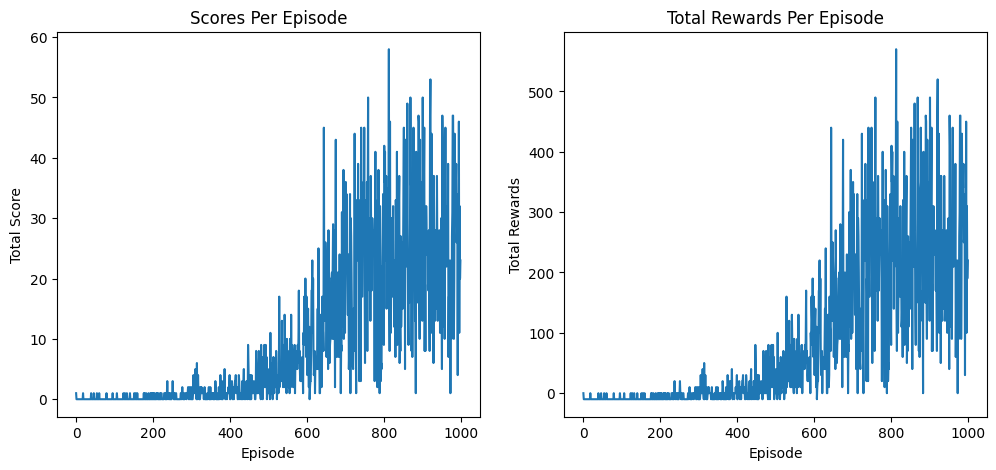

Average Number of steps taken by the model in each episode is:  264.073


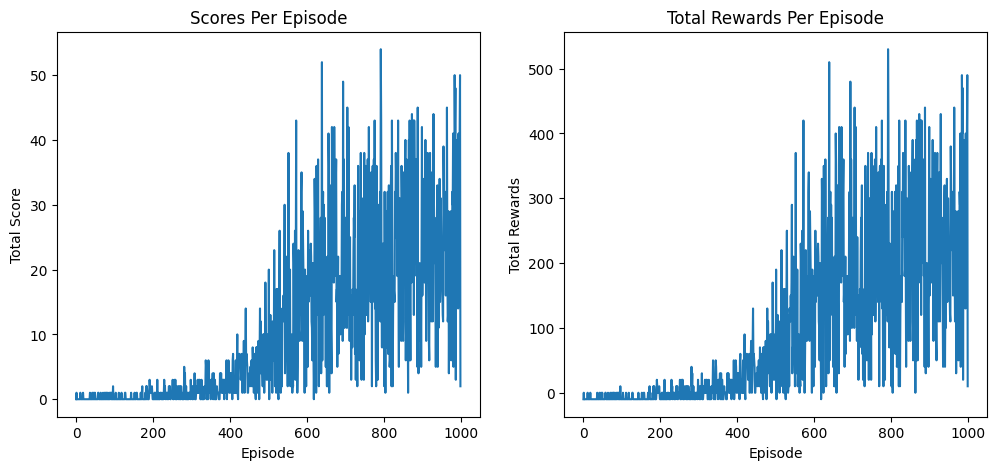

Average Number of steps taken by the model in each episode is:  262.859


/var/folders/b0/kmv3xkq15d348v9hg51y4r9h0000gn/T/ipykernel_31487/3882053096.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32)


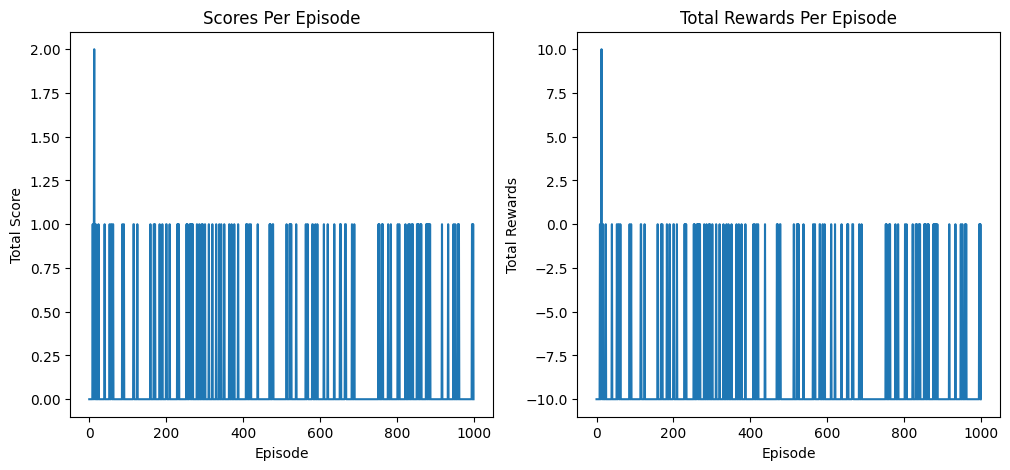

Average Number of steps taken by the model in each episode is:  322.185


In [18]:

# Main Function

if __name__ == "__main__":
    env = SnakeGameAI()

    #Train with Dueling DQN
    due_rewards, due_steps,due_scores = train_snake_game(env, num_episodes=1000)
    plot_results(due_scores, due_rewards)

    due_avg = sum(due_steps)/len(due_steps)
    print("Average Number of steps taken by the model in each episode is: ",due_avg)


    
    #Train with PER
    per_rewards, per_steps,per_scores = train_per_snake_game(env, num_episodes=1000)
    plot_results(per_scores, per_rewards)

    per_avg = sum(per_steps)/len(per_steps)
    print("Average Number of steps taken by the model in each episode is: ",per_avg)

    #Train with PPO
    ppo_rewards, ppo_steps,ppo_scores = train_snake_ppo(env, num_episodes=1000)
    plot_results(ppo_scores, ppo_rewards)

    ppo_avg = sum(ppo_steps)/len(ppo_steps)
    print("Average Number of steps taken by the model in each episode is: ",ppo_avg)
